In [1]:
import librosa
import time
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import csv
import IPython.display as ipd
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
#Keras
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras import callbacks
from tensorflow import math

from imblearn.over_sampling import SMOTE
from collections import Counter

import mo_tf
import timeit
from openvino.inference_engine import IECore

In [2]:
# reading dataset from csv
stat = 'abnormal normal'.split()
data_origin = pd.read_csv('data.csv')
data = data_origin.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.498098,0.010669,1355.627582,1632.530756,2984.921626,0.057413,-357.065765,169.752792,-46.861694,67.454842,...,-6.062041,7.387231,-9.862085,9.058959,-7.534760,6.535229,-7.786106,0.841553,-5.342541,abnormal
1,0.547494,0.005378,2092.622402,1828.059500,4161.029209,0.138394,-377.315643,148.194016,-77.071838,70.391685,...,-6.725280,8.314228,-12.819753,10.248579,-13.006725,10.588124,-9.434364,8.421089,-1.956536,abnormal
2,0.199319,0.010700,1204.431156,1604.841989,2387.287807,0.043510,-406.926331,171.354568,-22.173464,48.847950,...,-14.506110,-4.364563,-16.434780,5.844230,-15.634045,10.232363,-0.303717,11.974640,2.435613,abnormal
3,0.630616,0.009863,1470.761577,1672.928265,3238.448863,0.070529,-352.411194,169.718460,-56.841694,66.465225,...,-2.550473,11.814772,-10.915584,6.584901,-11.403391,8.936230,-5.264018,7.075547,-4.117052,abnormal
4,0.334657,0.009123,1375.252521,1677.441716,2785.252377,0.070988,-375.983185,176.464676,-42.045616,51.753513,...,4.838639,16.043678,-7.186187,12.683148,-15.059711,9.484856,-8.006330,9.391084,-2.548033,abnormal


In [3]:
sound_list = data.iloc[:, -1]
encoder = LabelEncoder()
y_origin = encoder.fit_transform(sound_list)
y = [1 if e == 0 else 0 for e in y_origin]
y = np.array(y)

In [4]:
# normalizing
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [5]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [6]:
# spliting of dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [7]:
# using SMOTE to upsample the minority class

counter = Counter(y_train)
print(counter)
# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print(counter)

Counter({0: 2572, 1: 907})
Counter({1: 2572, 0: 2572})


# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [8]:
# creating a basic model
def create_model(X_train):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    print(model.summary())
    return model

## Compile and train the model

In [9]:
model = create_model(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6912      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 48,194
Trainable params: 48,194
Non-trainable params: 0
_________________________________________________________________
None


2022-07-07 08:20:16.791823: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
checkpointer = callbacks.ModelCheckpoint(filepath="MLP_weights.hdf5", verbose=0, save_best_only=True)

epochs = 200

history = model.fit(X_train, y_train, epochs=epochs, batch_size=512, shuffle=True, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=0)

In [11]:
model.load_weights('MLP_weights.hdf5')

# Visualize training results

In [12]:
# Make a set of predictions for the validation data
pred = np.argmax(model.predict(X_test),axis=1)
conf = confusion_matrix(y_test, pred)


# Print performance details
print(classification_report(y_test, pred))
print("Confusion matrix")
print(conf)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       710
           1       0.80      0.81      0.80       257

    accuracy                           0.89       967
   macro avg       0.86      0.87      0.87       967
weighted avg       0.90      0.89      0.89       967

Confusion matrix
[[657  53]
 [ 49 208]]


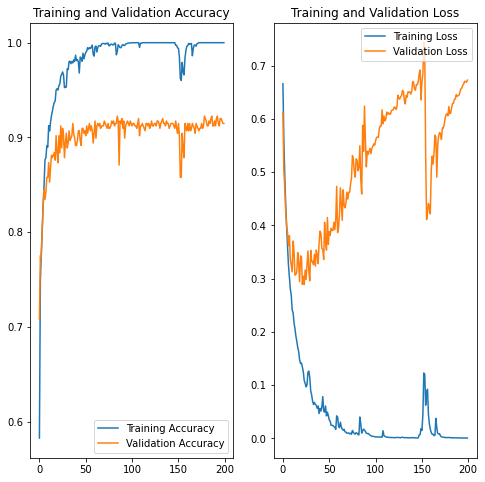

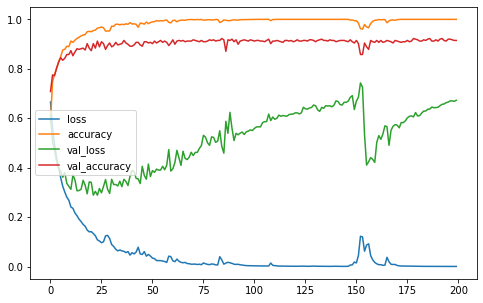

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

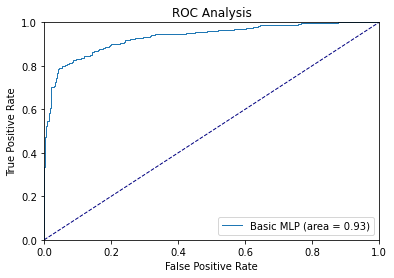

In [14]:
y_pred_proba_seq = model.predict(X_test)[::,1]
fpr_seq, tpr_seq, _ = roc_curve(y_test, y_pred_proba_seq)
roc_auc_seq = auc(fpr_seq, tpr_seq)

plt.figure()
lw = 1
plt.plot(fpr_seq, tpr_seq,
         lw=lw, label='Basic MLP (area = %0.2f)' % roc_auc_seq)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis')
plt.legend(loc="lower right")
plt.show()

# Save the TensorFlow Model

In [15]:
model_fname="saved_model"
model.save(model_fname)

2022-07-07 08:20:24.600879: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/assets


In [16]:
input_shape = [1, (X_train.shape[1])]

In [17]:
input_shape

[1, 26]

# Convert the TensorFlow model with OpenVINO Model Optimizer

In [18]:
# The paths of the source and converted models
model_name = "saved_model"
model_path = Path(model_name)
ir_data_type = "FP16"
ir_model_name = "model_ir"

# Get the path to the Model Optimizer script
mo_path = str(Path(mo_tf.__file__))

# Construct the command for Model Optimizer
mo_command = f""""{sys.executable}"
                 "{mo_path}" 
                 --saved_model_dir "{model_name}"
                 --input_shape "{input_shape}" 
                 --data_type "{ir_data_type}" 
                 --output_dir "{model_path.parent}"
                 --model_name "{ir_model_name}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
print(mo_command)

Model Optimizer command to convert TensorFlow to OpenVINO:
"/opt/anaconda3/bin/python" "/opt/anaconda3/lib/python3.7/site-packages/mo_tf.py" --saved_model_dir "saved_model" --input_shape "[1, 26]" --data_type "FP16" --output_dir "." --model_name "model_ir"


In [19]:
# Run the Model Optimizer (overwrites the older model)
print("Exporting TensorFlow model to IR... This may take a few minutes.")
mo_result = %sx $mo_command
print("\n".join(mo_result))

Exporting TensorFlow model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/Users/jamesmurphy/Desktop/Folders/PhD Project/Projects/MIMII/.
	- IR output name: 	model_ir
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1, 26]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with input

# OpenVINO Inference Engine Setup

In [20]:
class_names=["abnormal", "normal"]

model_xml = "model_ir.xml"
model_bin = "model_ir.bin"

# Load network to the plugin
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_bin)

# Neural Compute Stick
exec_net = ie.load_network(network=net, device_name=ie.available_devices[1])
#exec_net = ie.load_network(network=net, device_name="CPU")

del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

# Run the Inference Step

In [21]:
file_no = 0
input_wav = X_test[file_no]

res = exec_net.infer(inputs={input_layer: input_wav})
res = res[output_layer]

print(
    "This file most likely belongs to {} with a {:.2f} percent confidence.\n"
    .format(class_names[np.argmax(res)], 100 * np.max(res))
)

# actual status
res = y_test[file_no]
print('Actual Status: ',stat[res])

This file most likely belongs to normal with a 89.65 percent confidence.

Actual Status:  normal


In [22]:
out = []

def infer():
    for input_wav in X_test:
        res = exec_net.infer(inputs={input_layer: input_wav})
        res = res[output_layer]
        out.append(res)

itter = 10
total_time = (timeit.timeit(infer, number = itter)/itter)*1000
infer_time_ncs = (total_time / len(X_test))

print('Total Time for ' + str(len(X_test)) + ' Objects: ' + str(round(total_time, 2)) + 'ms')
print('Individual Inferrence Time ' + str(round(infer_time_ncs, 2)) + 'ms')

Total Time for 967 Objects: 1684.07ms
Individual Inferrence Time 1.74ms


# Run the Inference Step for CPU

In [23]:
net = ie.read_network(model=model_xml, weights=model_bin)

# Neural Compute Stick
exec_net = ie.load_network(network=net, device_name=ie.available_devices[0])

del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

In [24]:
out = []

def infer():
    for input_wav in X_test:
        res = exec_net.infer(inputs={input_layer: input_wav})
        res = res[output_layer]
        out.append(res)

itter = 10
total_time = (timeit.timeit(infer, number = itter)/itter)*1000
infer_time_cpu = (total_time / len(X_test))

print('Total Time for ' + str(len(X_test)) + ' Objects: ' + str(round(total_time, 2)) + 'ms')
print('Individual Inferrence Time ' + str(round(infer_time_cpu, 2)) + 'ms')

Total Time for 967 Objects: 117.36ms
Individual Inferrence Time 0.12ms


# Compare Runtimes

In [25]:
dif = infer_time_ncs - infer_time_cpu
times = infer_time_ncs / infer_time_cpu

print('Inferrence Times\n\n')
print(ie.available_devices[1] + ' Inferrence Time: ' + str(round(infer_time_ncs, 2)) + 'ms')
print(ie.available_devices[0] + ' Inferrence Time: ' + str(round(infer_time_cpu, 2)) + 'ms')
print('\nInferrence Time Difference: ' + str(round(dif, 2)) + 'ms')
print(ie.available_devices[0] + ' is ' + str(round(times, 2)) + ' times faster than ' + ie.available_devices[1])

Inferrence Times


MYRIAD Inferrence Time: 1.74ms
CPU Inferrence Time: 0.12ms

Inferrence Time Difference: 1.62ms
CPU is 14.35 times faster than MYRIAD


In [26]:
out

[array([[0.10356551, 0.8964345 ]], dtype=float32),
 array([[0.9949449 , 0.00505513]], dtype=float32),
 array([[9.9972743e-01, 2.7256308e-04]], dtype=float32),
 array([[0.9532754 , 0.04672458]], dtype=float32),
 array([[0.00199601, 0.998004  ]], dtype=float32),
 array([[0.9606094 , 0.03939061]], dtype=float32),
 array([[0.54410315, 0.45589685]], dtype=float32),
 array([[0.26632687, 0.73367316]], dtype=float32),
 array([[0.47207895, 0.527921  ]], dtype=float32),
 array([[9.9997985e-01, 2.0142235e-05]], dtype=float32),
 array([[0.00362187, 0.9963781 ]], dtype=float32),
 array([[0.00340742, 0.9965926 ]], dtype=float32),
 array([[0.93611616, 0.06388381]], dtype=float32),
 array([[0.02557193, 0.9744281 ]], dtype=float32),
 array([[0.99591273, 0.00408723]], dtype=float32),
 array([[0.12106127, 0.87893873]], dtype=float32),
 array([[0.96031755, 0.03968249]], dtype=float32),
 array([[7.246797e-09, 1.000000e+00]], dtype=float32),
 array([[0.02344212, 0.9765579 ]], dtype=float32),
 array([[2.8660